In [18]:
import pickle
import networkx as nx
import random
import grape
import numpy as np
from pecanpy import pecanpy
import time
from gensim.models import Word2Vec
import graphcuda
import os
import matplotlib.pyplot as plt
from tqdm import tqdm

folder = os.path.join(os.getcwd(), 'tmp')
if not os.path.exists(folder):
    os.makedirs(folder)
figures = os.path.join(os.getcwd(), 'figures')
if not os.path.exists(figures):
    os.makedirs(figures)

In [8]:
n_nodes   = 1000
prob_edge = 1.2/(100-1)

In [30]:
DIMENSIONS = 128
WALK_LEN = 100
NUM_WALKS = 10

grape_times = []
grape_walks = []
grape_embeddings = []

pecanpy_times = []
pecanpy_walks = []
pecanpy_embeddings = []

N = np.arange(1000, 10000, 1000, dtype=int)
N = np.insert(N, 0, 100, axis=0)
prob_edge = 1.2/(100-1)
for n in tqdm(N, position=0, desc='N', leave=False, ncols=80):
    G = graphcuda.generate_random_graph(n, prob_edge)
    temp_path = os.path.join(folder, 'graph.tsv')
    nx.write_weighted_edgelist(
        G, 
        temp_path, 
        delimiter='\t'
    )
    # GRAPE Model
    grape_model = grape.Graph.from_csv(
        # Edges related parameters

        ## The path to the edges list tsv
        edge_path=temp_path,
        ## Set the tab as the separator between values
        edge_list_separator="\t",
        ## The first rows should NOT be used as the columns names
        edge_list_header=False,
        ## The source nodes are in the first nodes
        sources_column_number=0,
        ## The destination nodes are in the second column
        destinations_column_number=1,
        ## Both source and destinations columns use numeric node_ids instead of node names
        edge_list_numeric_node_ids=True,
        ## The weights are in the third column
        weights_column_number=2,

        # Graph related parameters
        ## The graph is undirected
        directed=False,
        ## The name of the graph is HomoSapiens
        name="Temp Grape Graph",
        ## Display a progress bar, (this might be in the terminal and not in the notebook)
        verbose=True,
    )

    # PecanPy Model
    pecanpy_model = pecanpy.SparseOTF(
        p=1,
        q=2,
        workers=8,
        verbose=True
    )
    pecanpy_model.read_edg(temp_path, weighted=True, directed=False)

    start = time.time()
    walk = grape_model.complete_walks(
        walk_length=WALK_LEN,
        iterations=NUM_WALKS,
        return_weight=1, # p
        explore_weight=2 # q
    )
    end = time.time()
    grape_times.append(end - start)
    grape_walks.append(walk)

    start = time.time()
    walk = pecanpy_model.simulate_walks(
        num_walks=NUM_WALKS,
        walk_length=WALK_LEN,
    )
    end = time.time()
    pecanpy_times.append(end - start)
    pecanpy_walks.append(walk)

N:   0%|                                                 | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

N:  10%|████                                     | 1/10 [00:02<00:23,  2.59s/it]

  0%|          | 0/10000 [00:00<?, ?it/s]

N:  20%|████████▏                                | 2/10 [00:07<00:30,  3.76s/it]

  0%|          | 0/20000 [00:00<?, ?it/s]

N:  30%|████████████▎                            | 3/10 [00:14<00:37,  5.34s/it]

  0%|          | 0/30000 [00:00<?, ?it/s]

N:  40%|████████████████▍                        | 4/10 [00:24<00:42,  7.12s/it]

  0%|          | 0/40000 [00:00<?, ?it/s]

N:  50%|████████████████████▌                    | 5/10 [00:36<00:45,  9.07s/it]

  0%|          | 0/50000 [00:00<?, ?it/s]

N:  60%|████████████████████████▌                | 6/10 [00:51<00:44, 11.08s/it]

  0%|          | 0/60000 [00:00<?, ?it/s]

N:  70%|████████████████████████████▋            | 7/10 [01:09<00:39, 13.27s/it]

  0%|          | 0/70000 [00:00<?, ?it/s]

N:  80%|████████████████████████████████▊        | 8/10 [01:32<00:32, 16.24s/it]

  0%|          | 0/80000 [00:00<?, ?it/s]

N:  90%|████████████████████████████████████▉    | 9/10 [01:58<00:19, 19.26s/it]

  0%|          | 0/90000 [00:00<?, ?it/s]

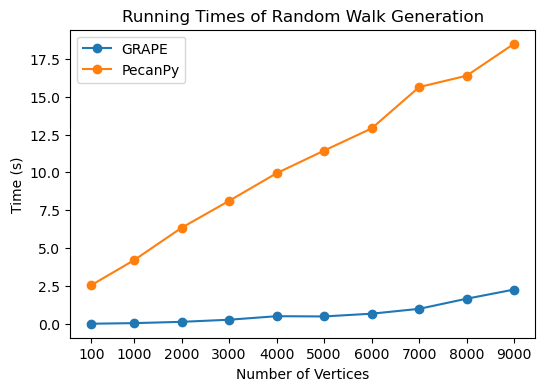

In [31]:
plt.figure(figsize=(6, 4))
plt.plot(N, grape_times, '-o', label='GRAPE')
plt.plot(N, pecanpy_times, '-o', label='PecanPy')
plt.xticks(N)
plt.title("Running Times of Random Walk Generation")
plt.xlabel("Number of Vertices")
plt.ylabel('Time (s)')
plt.legend()
plt.savefig('./figures/gen_times.png', dpi=300)